In [6]:
from pathlib import Path

cam_data = Path('pyronear_cam_data')

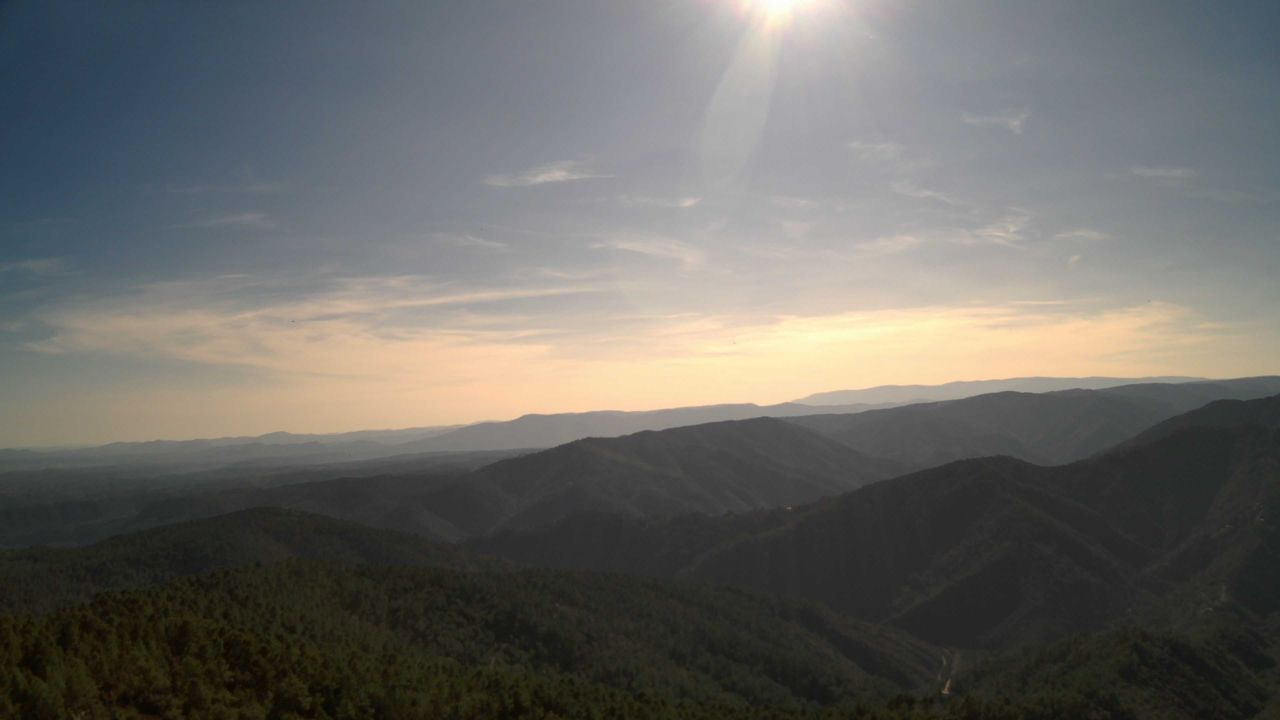

In [53]:
import pandas as pd
from PIL import Image

df = pd.read_csv(cam_data / 'API_DATA - devices.csv')
device = df[df.id == 7].squeeze()
img_path = list((cam_data / device.login).glob('*.jpg'))[0]
img = Image.open(img_path)
img

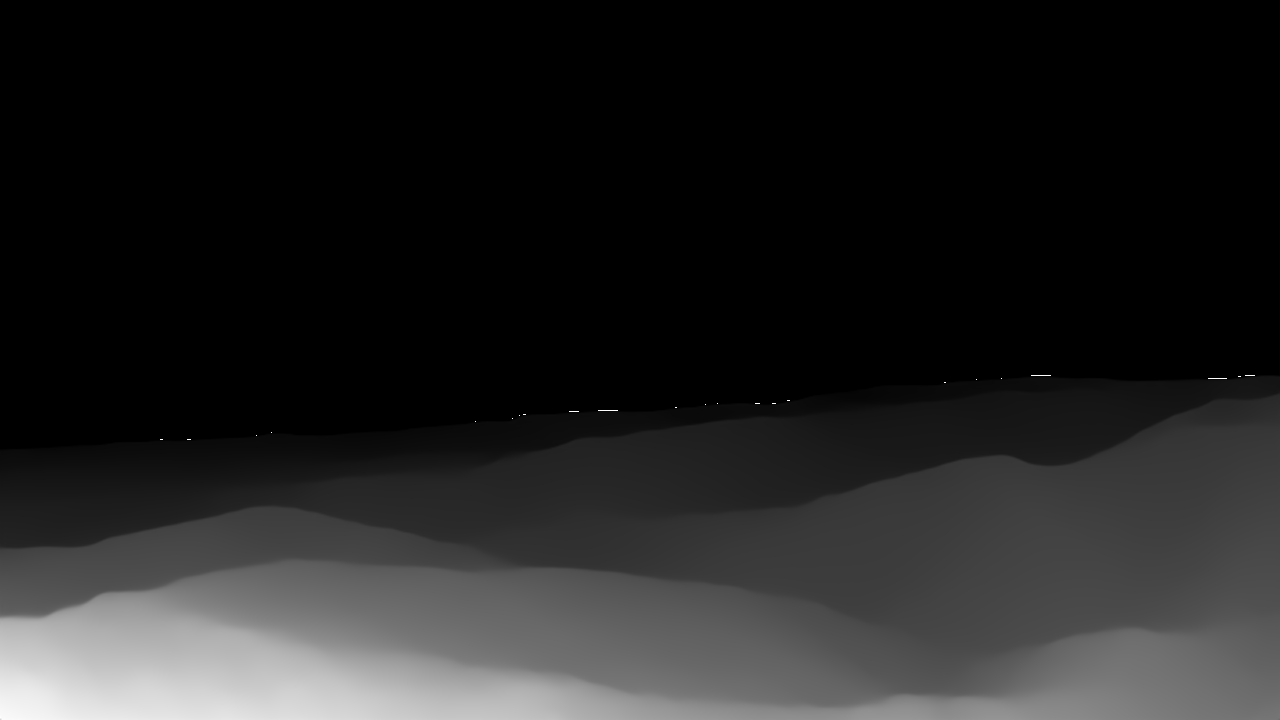

In [54]:
from transformers import pipeline

# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# inference
depth = pipe(img)["depth"]
depth

In [9]:
import math

AREA_KM = 50

lat, lon = device.lat, device.lon
dlat = (AREA_KM/2) / 111.11
dlon = dlat / math.cos(math.radians(lat))
bounds = [lon - dlon, lat - dlat, lon + dlon, lat + dlat]

In [10]:
import elevation as eio
eio.clip(bounds=bounds, output=Path.cwd() / 'dem.tiff', product='SRTM3')

make : on entre dans le répertoire « /home/mathias/.cache/elevation/SRTM3 »
make: Rien à faire pour « download ».
make : on quitte le répertoire « /home/mathias/.cache/elevation/SRTM3 »
make : on entre dans le répertoire « /home/mathias/.cache/elevation/SRTM3 »
make: Rien à faire pour « all ».
make : on quitte le répertoire « /home/mathias/.cache/elevation/SRTM3 »
make : on entre dans le répertoire « /home/mathias/.cache/elevation/SRTM3 »
cp SRTM3.vrt SRTM3.bfe873b288a04547b0e84b7cf61a5522.vrt
make : on quitte le répertoire « /home/mathias/.cache/elevation/SRTM3 »
make : on entre dans le répertoire « /home/mathias/.cache/elevation/SRTM3 »
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 3.9008291696998154 44.7701568215225 4.532239105700185 44.3201523214775 SRTM3.bfe873b288a04547b0e84b7cf61a5522.vrt /home/mathias/pyronear/dem.tiff
rm -f SRTM3.bfe873b288a04547b0e84b7cf61a5522.vrt
make : on quitte le répertoire « /home/mathias/.cache/elevation/SRT

In [11]:
import contextily as cx

_ = cx.bounds2raster(*bounds, 'satellite.tiff', ll=True, source=cx.providers.Esri.WorldImagery)

In [12]:
import rioxarray
from rasterio.crs import CRS

crs = CRS.from_dict(proj='tmerc', ellps='WGS84', lat_0=lat, lon_0=lon) #metric CRS centered on the camera

dem = rioxarray.open_rasterio('dem.tiff')
dem = dem.rio.reproject(crs)
dem = dem.rio.interpolate_na()

sat = rioxarray.open_rasterio('satellite.tiff')
sat = sat.rio.reproject(crs)
sat = sat.rio.clip_box(*dem.rio.bounds())

/home/mathias/pyronear/.venv/lib64/python3.11/site-packages/rioxarray/raster_array.py:1011: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_xds in self._obj.groupby(extra_dim):


In [13]:
meter_bounds = dem.rio.bounds()
x_spacing = (meter_bounds[2] - meter_bounds[0]) / dem.rio.shape[0]
y_spacing = (meter_bounds[3] - meter_bounds[1]) / dem.rio.shape[1]

In [27]:
import numpy as np
import pyvista as pv

arr = dem.to_numpy().transpose((1, 2, 0))
grid = pv.ImageData(
    dimensions = np.array(arr.shape) + 1,
    spacing=(x_spacing, y_spacing, 0),
    origin=(meter_bounds[0], meter_bounds[1], 0)
)
grid.cell_data["Elevation"] = arr.flatten(order='F') # Flatten the array
terrain = grid.ctp().warp_by_scalar("Elevation")

In [15]:
#terrain.texture_map_to_plane(use_bounds=True, inplace=True)
#texture = pv.numpy_to_texture(sat.to_numpy().transpose((1, 2, 0))).rotate_cw()
#terrain.plot(texture=texture, show_grid=True)

In [28]:
(w, h) = img.size

camera = pv.Camera()
camera.clipping_range = (30, 2e5)
camera.position = (0, 0, device.elevation)
camera.focal_point = (0, 1, device.elevation)
camera.up = (0, 0, 1)
camera.view_angle = device.angle_of_view*h/w
camera.azimuth = device.azimuth

pl = pv.Plotter(window_size=(w, h), lighting=None)
pl.camera = camera
pl.add_mesh(terrain)
pl.show()
zval = pl.get_image_depth()

Widget(value='<iframe src="http://localhost:42633/index.html?ui=P_0x7ff850bc7650_5&reconnect=auto" class="pyvi…

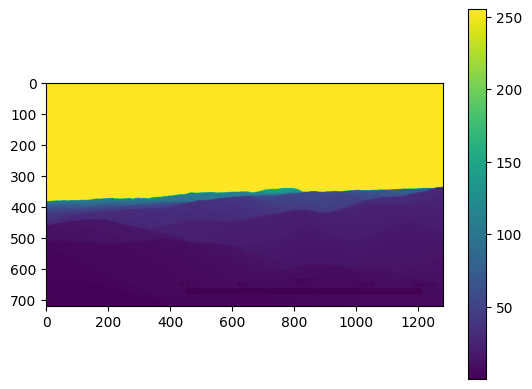

In [56]:
import matplotlib.pyplot as plt

plt.imshow(zval * 255 / zval.min())
plt.colorbar()

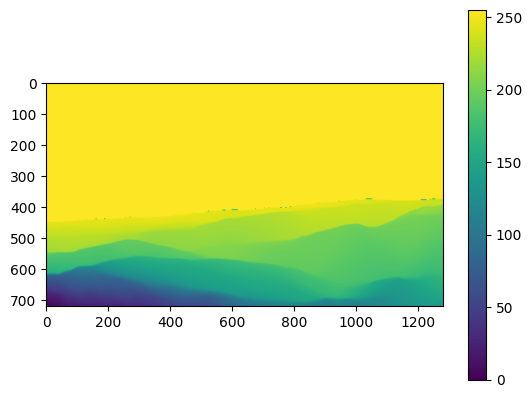

In [60]:
plt.imshow(255 - np.array(depth))
plt.colorbar()